In [1]:
import sys
sys.path.append('/home/lpodgorsek/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import pandas as pd
import multiprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from fastcluster import linkage
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model

In [2]:
def select_N_cells(data, num_of_cells):
    # data = (1,1024,128,1)
    # num_of_cells = 10
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    rand_vector = np.random.choice(np.flatnonzero(data_flatten), num_of_cells, replace=False)
    removed_cells = []
    
    for i in range(len(rand_vector)):
        v = data_flatten[rand_vector[i]]
        # removed_cells = [(100,1), (223, 1), (2244, 1), ...]
        removed_cells.append((rand_vector[i], v))
    return removed_cells

def save_test_cells(filename, data):
    f = uf.my_savez(filename)
    f.savez(data)
    f.close()
    
    
def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data


def remove_cells_from_data(data, list_of_cells):
    # data = (1,1024,128,1)
    # list_of_cells = [(111, 1.0), (2244, 0.34), ...]
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    for index, _ in list_of_cells:
        data_flatten[int(index)] = 0
        
    return data.reshape(1, row, col, 1)
        
    
    

def data_generator(filenames, org_data, batch_size=1, testing_cells=None, removed_cells=False):
    # n_pack => 1 samples of matrix
    # n_pack = batch_size
    # org_data = [[1,1024,128,1], [1,1024,256,1], [1,1024,1024,1]]
    # testing_cells = [[(111, 1.0), (2244, 0.34), ...], [(111, 1.0), (2244, 0.34), ...], ...]
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)  
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        y = []
        for i in range(len(files)):
            _x = []
            _y = []
            for j in range(batch_size):
                rand_num = np.random.randint(len(num_packs[i]))
                f = files[i]
                pack = num_packs[i]
                data = f[pack[rand_num]] 
                
                if testing_cells is not None and removed_cells:
                    data = remove_cells_from_data(data, testing_cells[i])

                _, row, col, _ = data.shape
                if col != 1021:
                    _x.append(f[pack[rand_num]])
                    _y.append(org_data[i])
            
            _x = np.asarray(_x)
            _y = np.asarray(_y)

            _x = _x[:, 0, :, :, :]
            _y = _y[:, 0, :, :, :]
        
            x.append(_x)
            y.append(_y)
            
        yield (x, y)
        
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data


def duplicateBatchData(data, batch=2):
    new_data = []
    for i in range(len(data)):
        b = []
        for j in range(batch):
            b.append(data[i])

        b = np.asarray(b)
        b = b[:,0,:,:,:]

        new_data.append(b)
        
    return new_data;

    
class MultiModal:
    
    def __init__(self, graph=None, path='', num_of_test_cells=10, load_test_cells=False):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.folder = path
        self.graph = graph
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        self.dropout = 0.5
        self.num_of_saved_cells = num_of_test_cells
        self.saved_cells_for_test = []
        self.predict_saved_cells_for_test = []
        self.is_first_iteration = True
        self.fake_org_data = []
        self.activation = 'relu'
        self.load_test_cells = load_test_cells
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
        
        for i in range(len(self.org_data)):
            self.fake_org_data.append(remove_cells_from_data(self.org_data[i], self.saved_cells_for_test[i]))
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                    
    def set_path_to_files(self, path):
        self.path = path
        self.filenames = []
        already = set()
        for obj in self.graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)
                    
    def set_path_to_folder(self, folder):
        self.folder = folder
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        
        data = np.array(relation.matrix).reshape(1,row,col,1)
#         new_data = top_N_rows(data)
        new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        if self.load_test_cells == True:
            test_cells = load_test_cells(self.folder + 'samples_' + relation.name + '.npz')
            self.saved_cells_for_test.append(test_cells)
            self.num_of_saved_cells = len(test_cells)
        else:
            test_cells = select_N_cells(new_data, self.num_of_saved_cells)
            self.saved_cells_for_test.append(test_cells)
            save_test_cells(self.folder + 'samples_' + relation.name, test_cells)
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(visible)
#         layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        if col == 1024:
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
#             layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
#             layer = MaxPooling2D((2, 2), padding='same')(layer)
            
        layer = Flatten()(layer)
        layer = Dense(1024, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(128, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(64, activation=self.activation)(layer)
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size
        layer = None
        
        if col == 128:
            layer = Reshape((64, 8, 2))(self.inputs)
        elif col == 256:
            layer = Reshape((64, 16, 1))(self.inputs)
        elif col == 1024:
            layer = Reshape((32, 32, 1))(self.inputs)
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
            layer = UpSampling2D((2, 2))(layer)
        
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        layer = Dense(128, activation=self.activation)(self.inputs)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(1024, activation=self.activation)(layer) 
        self.inputs = layer
        
    def _callbacks(self):
        log_dir = '/home/lpodgorsek/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
#             EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto'),
            
        ]
        
    def build_model(self, optimizer='sgd', loss='mse', metrics=['mae', 'acc'], gpu=1):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(64, activation=self.activation)(self.inputs) 
#         layer = concatenate(self.input_layers)
#         layer = Dense(512, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(256, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(128, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(64, activation=self.activation)(layer)
#         self.inputs = layer
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        
        try:
            with tf.device('/cpu:0'):
                self.model = multi_gpu_model(self.model, gpus=gpu, cpu_merge=True, cpu_relocation=True)
        except e:
            print(e)
            pass
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.saved_cells_for_test, self.is_first_iteration), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        self.is_first_iteration = False
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict_hidden_cells(self):
        list_of_predict = {}
            
        print()
        print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
        print("---------------------------------------------------------------------------------------")
        avg_diff = np.zeros(len(self.saved_cells_for_test))
        for i in range(len(self.saved_cells_for_test[0])):
            for j in range(len(self.saved_cells_for_test)):
                idx, val = self.saved_cells_for_test[j][i]
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff[j] += diff_abs
                
                if j not in list_of_predict:
                    list_of_predict[j] = [(idx, predict_val)] 
                else:
                    list_of_predict[j].append((idx, predict_val)) 
                print(str(self.saved_cells_for_test[j][i]) + ' ' + format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
            print()
        print("---------------------------------------------------------------------------------------")

        for i in range(len(avg_diff)):
            val = avg_diff[i]*100/len(self.saved_cells_for_test[0])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
        
        for i in range(len(list_of_predict)):
            self.predict_saved_cells_for_test.append(list_of_predict[i])
        
    def predict_generator(self, batch_size=10, iteration=1):
        predict = self.model.predict_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size),
            steps=100
        )

        for i in range(len(self.org_data)):
            _,row, col,_ = predict[i].shape
            print(predict[i].shape)
            mse = 0
            for j in range(predict[i].shape[0]):
                mse += mean_squared_error(self.org_data[i].flatten(), predict[i][j].flatten())

            print('MSE' + str(i+1) + ': ' + format(mse*100/predict[i].shape[0], '.5f'))
            print()

            if col == 128:
                filename = self.folder + 'predict_' + str(iteration) + '_ann.npz'
            elif col == 256:
                filename = self.folder + 'predict_' + str(iteration) + '_expr.npz'
            elif col == 1024:
                filename = self.folder + 'predict_' + str(iteration) + '_ppi.npz'
            else:
                raise ValueError("ERROR: wrong data!!")
                
            f = uf.my_savez(filename)

            for j in range(predict[i].shape[0]):
                data = predict[i][j].reshape(1, row, col, 1)
                f.savez(data)
            f.close()
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
    def predictMultiGPU(self, random=False, gpu=1):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        if gpu == 1:
            self.predict_data = self.model.predict(self.org_data)
            self.base_line = self.model.predict(self.shuffled_data)

    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())

                non_zeros = self.org_data[i].flatten()
                non_zeros[self.org_data[i].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
                print(outputBody)
                
        else:            
            self.predict_data = self.model.predict(duplicateBatchData(self.org_data, gpu))
            self.base_line = self.model.predict(duplicateBatchData(self.shuffled_data, gpu))
            
    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i][0].flatten(), self.predict_data[i][0].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i][0].flatten(), self.base_line[i][0].flatten())

                non_zeros = self.org_data[i][0].flatten()
                non_zeros[self.org_data[i][0].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i][0].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i][0].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i][0])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i][0].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i][0].flatten()), 5)) + '\t'
                print(outputBody)

In [3]:
numOfExperiment = 'model_weigth'
epchos = 5
GPU = 3
batch_size = 3 * GPU
# path_data = '/data/samples/multiple_inputs_clustering/dicty/'
# folder = '/home/lpodgorsek/data/cnn/dicty/_00/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_05/'
    folder = '/home/lpodgorsek/data/cnn/dicty/_10/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_25/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_50/'
graph1 = load_dicty('clustering', 2)

model = MultiModal(graph=graph1, path=folder, num_of_test_cells=100, load_test_cells=False)
#     model.build_model(optimizer='sgd', loss='mse')
#     loss='binary_crossentropy'
model.build_model(optimizer='adadelta', loss='binary_crossentropy', metrics=['mae', 'acc'], gpu=GPU)
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 1)

model.set_path_to_files(folder + 'predict_1_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 2)

model.set_path_to_files(folder + 'predict_2_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 3)

model.set_path_to_files(folder + 'predict_3_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()

In [3]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_10/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		0.25206% 	8.91828% 	0.04888		0.04572		0.0		1.0	
(1024,256) 	95.4% 		0.45863% 	6.42776% 	0.82382		0.82777		0.0		0.98908	
(1024,1024) 	3.04% 		1.86944% 	2.30517% 	0.02452		0.00343		0.0		0.6725	


In [4]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(46206, 1.0) 1.00000 1.00000 0.00000 	(60333, 0.8987571959975301) 0.87613 0.89876 0.02262 	(208581, 0.08362779740871625) 0.00921 0.08363 0.07442 	
(70949, 1.0) 0.99987 1.00000 0.00013 	(212782, 0.9072087801496445) 0.88332 0.90721 0.02389 	(442522, 0.9281507656065962) 0.05577 0.92815 0.87238 	
(51453, 1.0) 1.00000 1.00000 0.00000 	(261574, 0.8207256730386322) 0.82595 0.82073 0.00522 	(546369, 0.8433451118963486) 0.04872 0.84335 0.79462 	
(25874, 1.0) 0.99957 1.00000 0.00043 	(194701, 0.874919834557355) 0.88305 0.87492 0.00813 	(201061, 0.9340400471142521) 0.05090 0.93404 0.88314 	
(81154, 1.0) 1.00000 1.00000 0.00000 	(213347, 0.9049981391145635) 0.91186 0.90500 0.00686 	(470592, 0.7714958775029447) 0.01960 0.77150 0.75189 	
(6662, 1.0) 1.00000 1.00000 0.00000 	(98252, 0.8404654088622093) 0.84090 0.84047 0.00043 	(313497, 0.729093

(9484, 1.0) 1.00000 1.00000 0.00000 	(183267, 0.8558833919612528) 0.86558 0.85588 0.00970 	(99504, 0.9116607773851589) 0.07014 0.91166 0.84152 	
(5648, 1.0) 0.78864 1.00000 0.21136 	(116304, 0.877938858829778) 0.90967 0.87794 0.03173 	(644359, 0.7997644287396938) 0.02481 0.79976 0.77496 	
(73629, 1.0) 1.00000 1.00000 0.00000 	(171911, 0.8569220623838357) 0.88800 0.85692 0.03107 	(7191, 0.6136631330977621) 0.35079 0.61366 0.26287 	
(100736, 1.0) 1.00000 1.00000 0.00000 	(11721, 0.8758626419140517) 0.90845 0.87586 0.03259 	(286133, 0.9740871613663132) 0.04223 0.97409 0.93186 	
(7814, 1.0) 0.99995 1.00000 0.00005 	(76718, 0.8957126228169568) 0.87566 0.89571 0.02005 	(234950, 0.9882214369846879) 0.07240 0.98822 0.91582 	
(48003, 1.0) 1.00000 1.00000 0.00000 	(64538, 0.8093629175200118) 0.84305 0.80936 0.03369 	(821403, 0.8881036513545347) 0.00584 0.88810 0.88226 	
(86658, 1.0) 1.00000 1.00000 0.00000 	(127017, 0.8399891445829528) 0.85287 0.83999 0.01288 	(136589, 0.4475853945818611) 0.0675

(5692, 1.0) 0.81033 1.00000 0.18967 	(215660, 0.8980934815856734) 0.91044 0.89809 0.01235 	(282625, 0.7997644287396938) 0.12528 0.79976 0.67448 	
(14592, 1.0) 1.00000 1.00000 0.00000 	(92711, 0.8394223508237271) 0.87777 0.83942 0.03835 	(226343, 0.9988221436984688) 0.14459 0.99882 0.85423 	
(6788, 1.0) 1.00000 1.00000 0.00000 	(102168, 0.8982979021889477) 0.88223 0.89830 0.01607 	(137707, 0.7408716136631333) 0.03560 0.74087 0.70528 	
(4103, 1.0) 0.53986 1.00000 0.46014 	(95675, 0.8376414219904255) 0.84913 0.83764 0.01149 	(111843, 0.8928150765606597) 0.06820 0.89282 0.82461 	
(38785, 1.0) 0.98629 1.00000 0.01371 	(43583, 0.7963174995484005) 0.87187 0.79632 0.07556 	(132330, 0.9375736160188458) 0.09140 0.93757 0.84618 	
(1570, 1.0) 0.14111 1.00000 0.85889 	(41239, 0.9054938153962031) 0.85329 0.90549 0.05220 	(292291, 0.9493521790341579) 0.05956 0.94935 0.88979 	
(38142, 1.0) 1.00000 1.00000 0.00000 	(92017, 0.9373055651251918) 0.88114 0.93731 0.05616 	(448564, 0.9093050647820966) 0.0567

(5393, 1.0) 0.97772 1.00000 0.02228 	(216883, 0.9139270506442266) 0.89753 0.91393 0.01639 	(320108, 0.8480565371024736) 0.02456 0.84806 0.82349 	
(66819, 1.0) 0.99096 1.00000 0.00904 	(42469, 0.8612453442140533) 0.88539 0.86125 0.02414 	(36904, 0.8798586572438163) 0.20810 0.87986 0.67176 	
(6032, 1.0) 0.38415 1.00000 0.61585 	(148027, 0.9440106111662947) 0.91781 0.94401 0.02620 	(830007, 0.5724381625441697) 0.01132 0.57244 0.56111 	
(123905, 1.0) 1.00000 1.00000 0.00000 	(80019, 0.8853269100780624) 0.87570 0.88533 0.00963 	(22801, 0.9352179034157833) 0.12697 0.93522 0.80825 	
(78080, 1.0) 1.00000 1.00000 0.00000 	(48595, 0.8811699479749616) 0.84782 0.88117 0.03335 	(472317, 0.9234393404004712) 0.02307 0.92344 0.90037 	
(40962, 1.0) 0.99999 1.00000 0.00001 	(137827, 0.8763367038964626) 0.88455 0.87634 0.00822 	(36918, 0.9764428739693758) 0.20810 0.97644 0.76834 	
(20360, 1.0) 0.89681 1.00000 0.10319 	(64401, 0.8467098416447545) 0.84700 0.84671 0.00029 	(198658, 0.5618374558303887) 0.266

(1149, 1.0) 0.94504 1.00000 0.05496 	(173847, 0.8685185098020872) 0.87631 0.86852 0.00779 	(150627, 0.8833922261484101) 0.12840 0.88339 0.75499 	
(41854, 1.0) 1.00000 1.00000 0.00000 	(215420, 0.9317431190077191) 0.90115 0.93174 0.03059 	(8205, 0.9411071849234394) 0.35561 0.94111 0.58550 	
(103168, 1.0) 1.00000 1.00000 0.00000 	(192614, 0.8942889656249978) 0.87979 0.89429 0.01450 	(202309, 0.11425206124852769) 0.04573 0.11425 0.06852 	
(1540, 1.0) 0.72297 1.00000 0.27703 	(131909, 0.8667421001527117) 0.88697 0.86674 0.02023 	(635729, 0.5747938751472321) 0.00049 0.57479 0.57430 	
(48389, 1.0) 0.99891 1.00000 0.00109 	(192661, 0.8827326518215961) 0.88399 0.88273 0.00126 	(58761, 0.9752650176678446) 0.03995 0.97527 0.93532 	
(98435, 1.0) 1.00000 1.00000 0.00000 	(94473, 0.8818714622907714) 0.85525 0.88187 0.02662 	(194663, 0.9988221436984688) 0.19183 0.99882 0.80700 	
(104322, 1.0) 1.00000 1.00000 0.00000 	(66198, 0.8030849084641658) 0.85014 0.80308 0.04705 	(122061, 0.7491166077738517) 0

(48266, 1.0) 0.99433 1.00000 0.00567 	(239989, 0.8768324897886696) 0.88147 0.87683 0.00464 	(11482, 0.7361601884570083) 0.12515 0.73616 0.61101 	
(669, 1.0) 0.29715 1.00000 0.70285 	(22344, 0.7517428792464449) 0.67606 0.75174 0.07568 	(199769, 0.9988221436984688) 0.09736 0.99882 0.90146 	
(13842, 1.0) 0.99834 1.00000 0.00166 	(71681, 0.9768860145025257) 0.90087 0.97689 0.07602 	(299146, 0.8374558303886925) 0.12630 0.83746 0.71116 	
(3502, 1.0) 0.07790 1.00000 0.92210 	(261349, 0.829888065361846) 0.80402 0.82989 0.02587 	(685100, 0.790341578327444) 0.01704 0.79034 0.77330 	
(5383, 1.0) 0.79374 1.00000 0.20626 	(97983, 0.8717963869394338) 0.85920 0.87180 0.01259 	(267666, 0.9340400471142521) 0.02712 0.93404 0.90692 	
(9600, 1.0) 1.00000 1.00000 0.00000 	(81767, 0.8997558724124354) 0.89431 0.89976 0.00545 	(138294, 0.8916372202591284) 0.20810 0.89164 0.68354 	
(57090, 1.0) 0.99728 1.00000 0.00272 	(17459, 0.7456516661403874) 0.72141 0.74565 0.02424 	(409699, 0.6584216725559483) 0.06251 0.

(41746, 1.0) 0.99986 1.00000 0.00014 	(15971, 0.8404514377203427) 0.58511 0.84045 0.25534 	(25024, 0.8869257950530036) 0.16419 0.88693 0.72273 	
(27285, 1.0) 0.99970 1.00000 0.00030 	(21871, 0.7578075195412411) 0.78545 0.75781 0.02764 	(187752, 0.9281507656065962) 0.04820 0.92815 0.87995 	
(37912, 1.0) 0.92939 1.00000 0.07061 	(71106, 0.8714908362574727) 0.86620 0.87149 0.00529 	(473516, 0.9163722025912839) 0.04103 0.91637 0.87534 	
(23579, 1.0) 0.99992 1.00000 0.00008 	(221601, 0.8649227697179942) 0.88197 0.86492 0.01705 	(163308, 0.016489988221436967) 0.07346 0.01649 0.05697 	
(122625, 1.0) 1.00000 1.00000 0.00000 	(134965, 0.8064326357098867) 0.85473 0.80643 0.04830 	(754737, 0.9116607773851589) 0.20528 0.91166 0.70638 	
(34428, 1.0) 1.00000 1.00000 0.00000 	(108941, 0.8766684879677772) 0.88218 0.87667 0.00551 	(434757, 0.7526501766784454) 0.02373 0.75265 0.72892 	
(10251, 1.0) 0.99773 1.00000 0.00227 	(249507, 0.8992093663348555) 0.88462 0.89921 0.01459 	(408979, 0.9517078916372204

(10882, 1.0) 0.99981 1.00000 0.00019 	(259791, 0.8453019749740149) 0.82463 0.84530 0.02067 	(28761, 0.917550058892815) 0.24053 0.91755 0.67702 	
(12049, 1.0) 0.99872 1.00000 0.00128 	(78614, 0.8097185775181324) 0.87212 0.80972 0.06240 	(202781, 0.9623085983510011) 0.12556 0.96231 0.83675 	
(34309, 1.0) 1.00000 1.00000 0.00000 	(234652, 0.8774492721040886) 0.88147 0.87745 0.00402 	(7485, 0.9964664310954064) 0.08973 0.99647 0.90673 	
(112513, 1.0) 1.00000 1.00000 0.00000 	(157461, 0.8380371166440558) 0.85934 0.83804 0.02130 	(700063, 0.917550058892815) 0.02431 0.91755 0.89324 	
(96256, 1.0) 0.99342 1.00000 0.00658 	(20965, 0.8123103690555026) 0.85313 0.81231 0.04082 	(2132, 0.7526501766784454) 0.23202 0.75265 0.52063 	
(57344, 1.0) 0.99995 1.00000 0.00005 	(160882, 0.8308560372016943) 0.88148 0.83086 0.05062 	(624221, 0.9517078916372204) 0.14221 0.95171 0.80949 	
(15109, 1.0) 1.00000 1.00000 0.00000 	(167378, 0.8388895168472127) 0.88113 0.83889 0.04224 	(880668, 0.917550058892815) 0.0086

(47618, 1.0) 1.00000 1.00000 0.00000 	(69019, 0.936911780171551) 0.88401 0.93691 0.05290 	(289951, 0.8244994110718493) 0.09762 0.82450 0.72688 	
(47106, 1.0) 1.00000 1.00000 0.00000 	(42434, 0.8687808520072814) 0.92172 0.86878 0.05294 	(322847, 0.6584216725559483) 0.09221 0.65842 0.56621 	
(64303, 1.0) 0.99993 1.00000 0.00007 	(170374, 0.8841771956369935) 0.88278 0.88418 0.00140 	(669762, 0.46525323910482924) 0.06382 0.46525 0.40143 	
(6802, 1.0) 0.99994 1.00000 0.00006 	(205478, 0.843851430928474) 0.88170 0.84385 0.03785 	(577691, 0.8881036513545347) 0.04780 0.88810 0.84030 	
(47099, 1.0) 1.00000 1.00000 0.00000 	(136261, 0.830071608968219) 0.86672 0.83007 0.03665 	(107710, 0.9988221436984688) 0.15497 0.99882 0.84385 	
(52747, 1.0) 1.00000 1.00000 0.00000 	(64587, 0.8044102070786906) 0.85059 0.80441 0.04618 	(202973, 0.5877502944640753) 0.09931 0.58775 0.48844 	
(7933, 1.0) 1.00000 1.00000 0.00000 	(23508, 0.8414713578711542) 0.86305 0.84147 0.02158 	(41027, 0.9340400471142521) 0.2081

(81792, 1.0) 1.00000 1.00000 0.00000 	(207459, 0.8606117271675738) 0.88147 0.86061 0.02086 	(758790, 0.7938751472320377) 0.04799 0.79388 0.74589 	
(15888, 1.0) 0.98674 1.00000 0.01326 	(240299, 0.8668761080133601) 0.88123 0.86688 0.01436 	(14337, 0.7467608951707894) 0.31708 0.74676 0.42968 	
(95104, 1.0) 1.00000 1.00000 0.00000 	(192538, 0.8999279573456598) 0.89273 0.89993 0.00720 	(639233, 0.9787985865724382) 0.02005 0.97880 0.95875 	
(73216, 1.0) 1.00000 1.00000 0.00000 	(153480, 0.8251870710730416) 0.84099 0.82519 0.01581 	(337471, 0.7773851590106008) 0.02514 0.77739 0.75224 	
(4883, 1.0) 0.91636 1.00000 0.08364 	(129695, 0.8314209212480462) 0.85869 0.83142 0.02727 	(11366, 0.8928150765606597) 0.32501 0.89282 0.56781 	
(124161, 1.0) 1.00000 1.00000 0.00000 	(149081, 0.9313829454114189) 0.93049 0.93138 0.00089 	(765239, 0.7608951707891638) 0.00583 0.76090 0.75507 	
(19585, 1.0) 0.96763 1.00000 0.03237 	(32300, 0.786673423267813) 0.82413 0.78667 0.03746 	(363266, 0.7302709069493521) 0

(770, 1.0) 0.66475 1.00000 0.33525 	(73664, 0.8775040433864453) 0.86005 0.87750 0.01746 	(394292, 0.7561837455830389) 0.09170 0.75618 0.66448 	
(6016, 1.0) 0.98532 1.00000 0.01468 	(222802, 0.864024119833488) 0.90621 0.86402 0.04218 	(630823, 0.994110718492344) 0.18107 0.99411 0.81304 	
(87680, 1.0) 1.00000 1.00000 0.00000 	(245184, 0.8847193247554402) 0.88147 0.88472 0.00325 	(148976, 0.07067137809187285) 0.16502 0.07067 0.09435 	
(28680, 1.0) 0.99347 1.00000 0.00653 	(183038, 0.8373133983489388) 0.84408 0.83731 0.00676 	(111866, 0.9140164899882215) 0.07728 0.91402 0.83674 	
(89088, 1.0) 0.99995 1.00000 0.00005 	(112442, 0.9435445360637945) 0.94579 0.94354 0.00225 	(152578, 0.9623085983510011) 0.27698 0.96231 0.68532 	
(40967, 1.0) 0.99832 1.00000 0.00168 	(214065, 0.8954995246083176) 0.88147 0.89550 0.01403 	(488600, 0.956419316843345) 0.03880 0.95642 0.91762 	
(45827, 1.0) 1.00000 1.00000 0.00000 	(66025, 0.7914176499394617) 0.84718 0.79142 0.05576 	(206162, 0.8881036513545347) 0.06

(15744, 1.0) 1.00000 1.00000 0.00000 	(50500, 0.8985621049344806) 0.86578 0.89856 0.03278 	(1212, 0.8398115429917551) 0.18263 0.83981 0.65718 	
(57103, 1.0) 0.64017 1.00000 0.35983 	(230622, 0.871834204514931) 0.88067 0.87183 0.00883 	(602160, 0.9116607773851589) 0.14070 0.91166 0.77097 	
---------------------------------------------------------------------------------------
		6.38016%			2.86264%			70.18429%	


(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0


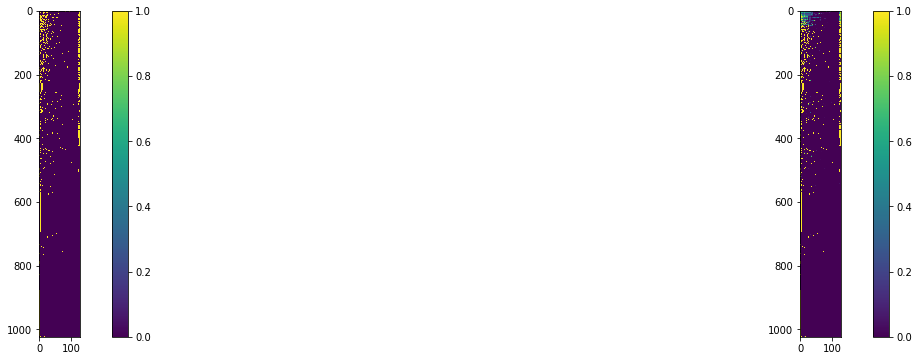

3.8773607e-10
0.9890844


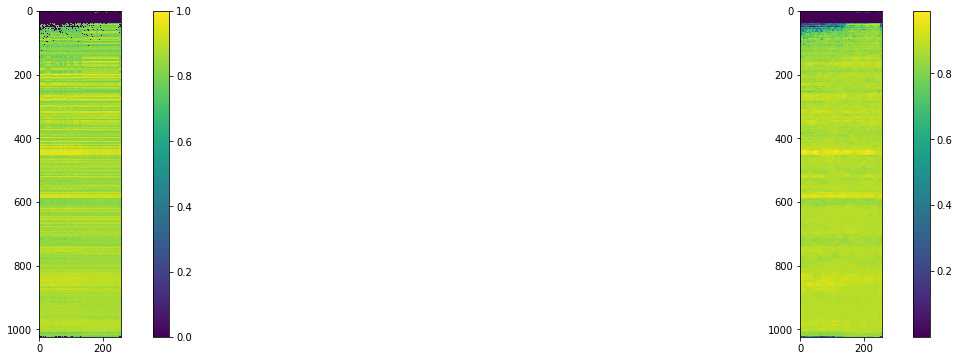

4.5613358e-09
0.6725026


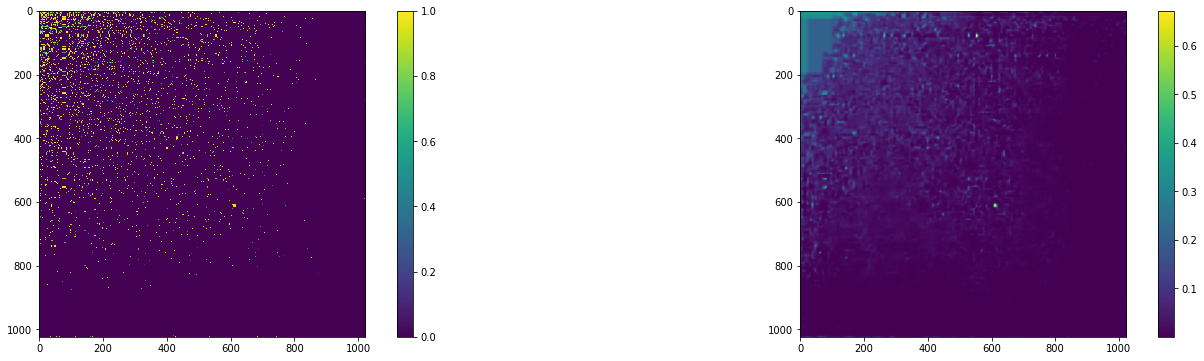

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/_10/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
# color_pack2 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

#     ax = axes[2]
#     im = ax.imshow(predict - org_data, vmin=-1, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:385: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


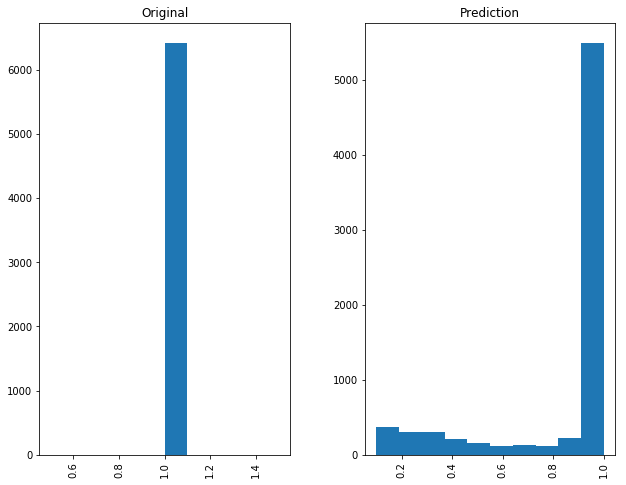

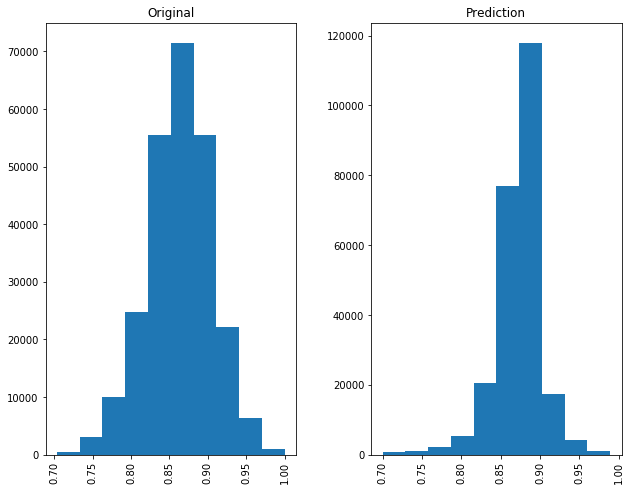

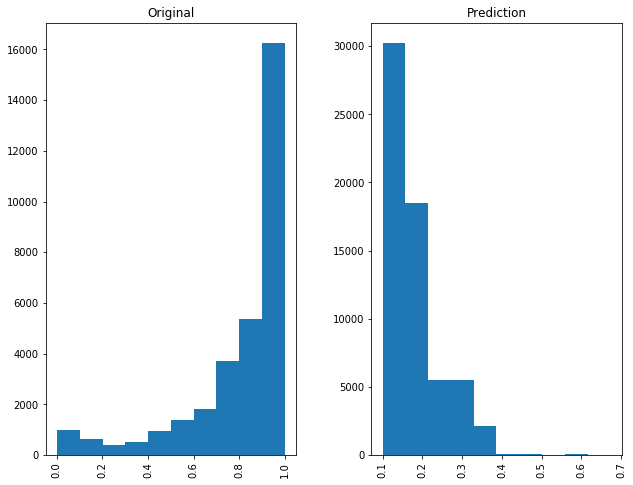

In [6]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'histogram_distribution_' + str(i))
    

/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/__init__.py:62: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


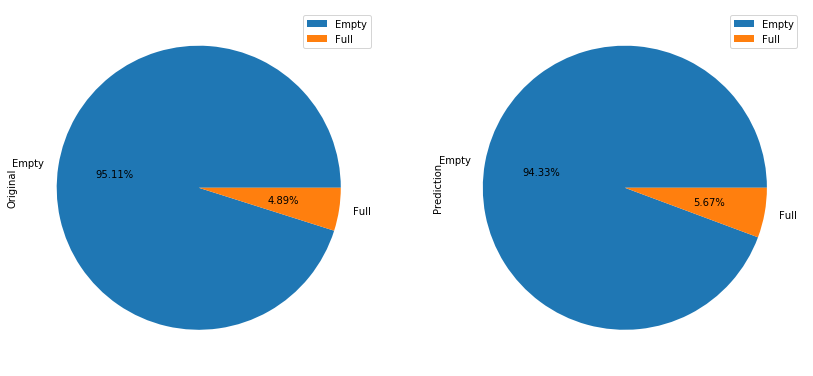

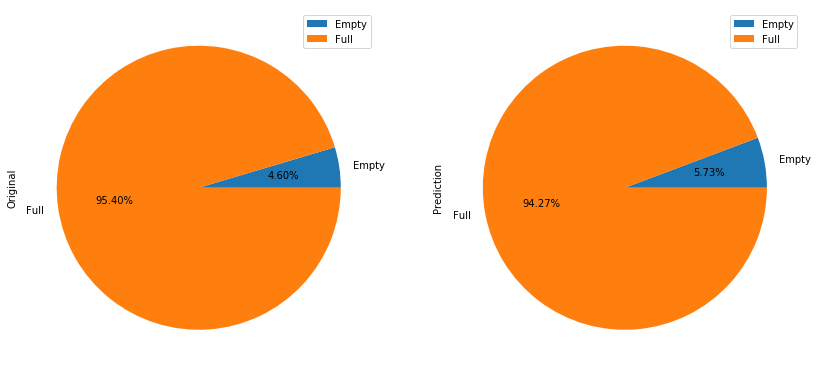

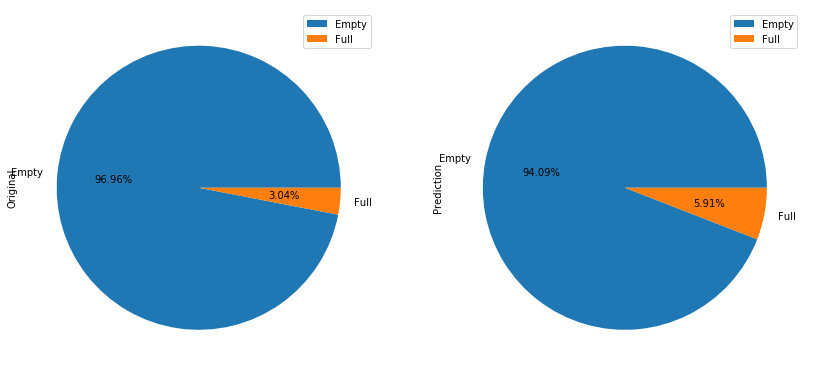

In [7]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    length = len(org_data)
    d = {}
    d['Original'] = []
    d['Original'].append(len(org_data[org_data == 0]) / length)
    d['Original'].append(len(org_data[org_data > 0]) / length)

    if i == 1:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.7]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.7]) / length)
    else:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.1]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.1]) / length)

    fig, ax = plt.subplots(figsize=(14,8))
    df = pd.DataFrame(d, index=['Empty', 'Full'])
    df.plot.pie(subplots=True, figsize=(14, 8), autopct='%.2f%%', ax=ax)
    fig.savefig(path + 'pie_density_' + str(i))

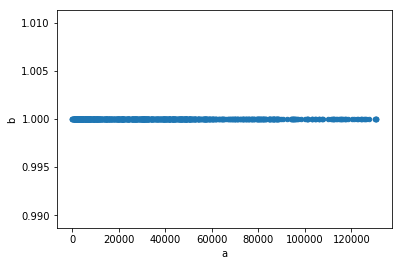

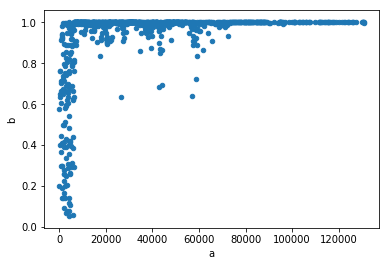

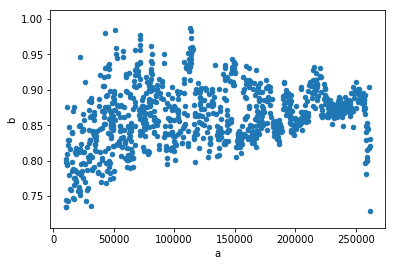

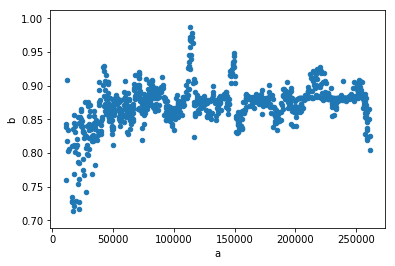

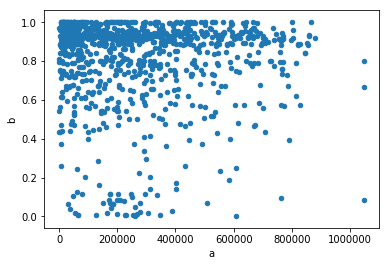

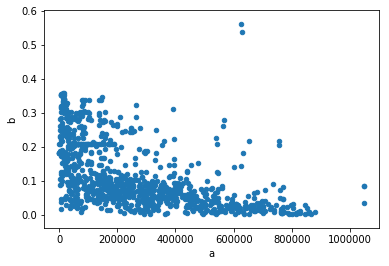

In [8]:
for i in range(len(model.org_data)):
    # df.plot.scatter(x='a', y='b');
    # print(np.random.rand(50, 4))
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    # print(data)
    new_org_data = []
    new_predict_data = []
    for j in range(len(org_data)):
        if i == 1:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            if predict_data[j][1] > 0.7:
                new_predict_data.append([predict_data[j][0], predict_data[j][1]])
        else:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            new_predict_data.append([predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(new_org_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    df = pd.DataFrame(new_predict_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    new_predict_data

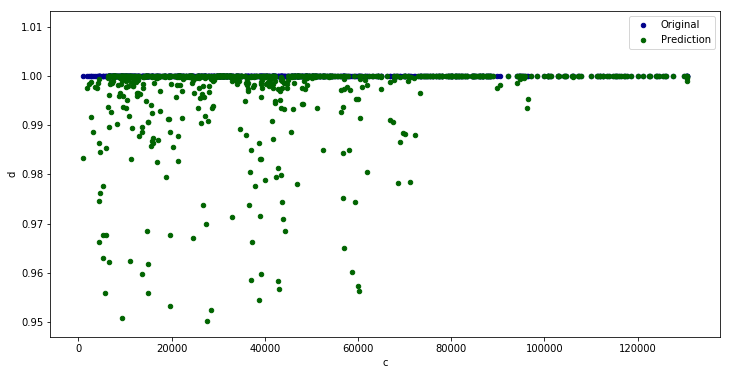

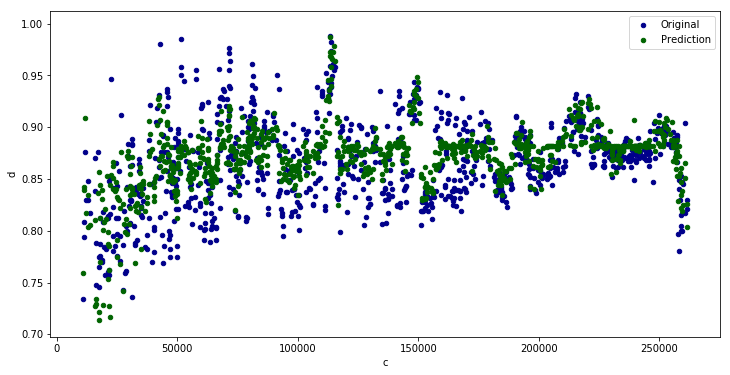

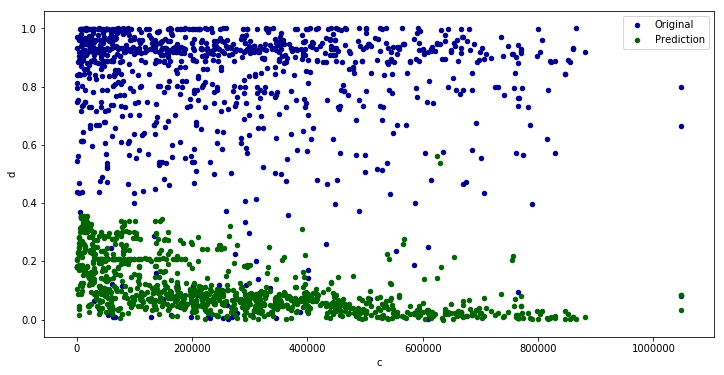

In [9]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original');
    df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));

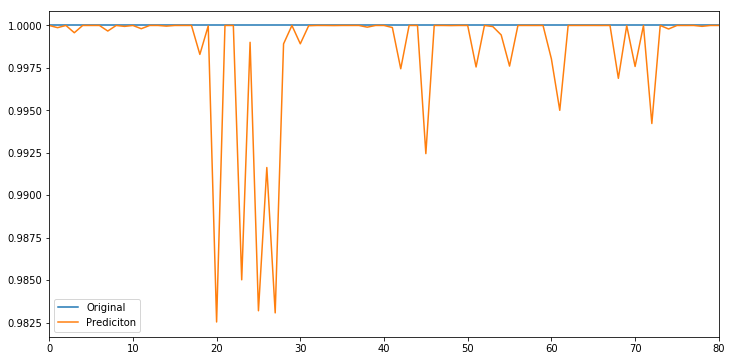

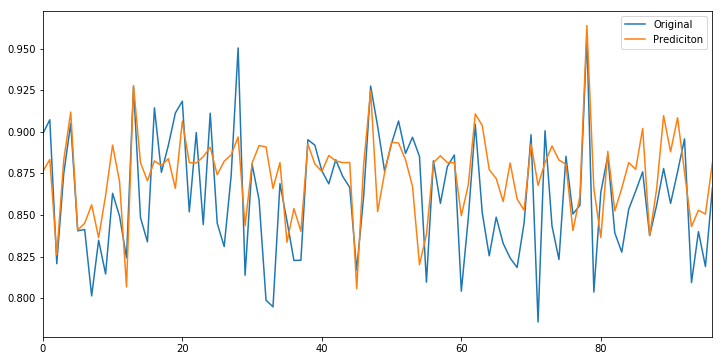

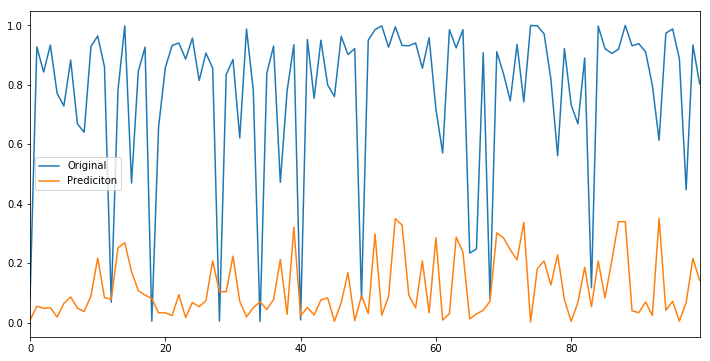

In [10]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data[:100])):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][1], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][1], predict_data[j][1]])
        else:
            data.append([org_data[j][1], predict_data[j][1]])

    fig, ax = plt.subplots(figsize=(12,6))
    df = pd.DataFrame(data, columns=['Original', 'Prediciton'])
    df.plot(subplots=False, figsize=(12,6), ax=ax)
    fig.savefig(path + 'graph_org_vs_prediction_' + str(i))